In [191]:
import netCDF4 as nc
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [192]:
f = nc.Dataset("sst.mon.mean.nc")
all_vars = f.variables.keys()   # get all keys
all_vars_info = f.variables.items()   # output: <class 'dict_items'>
### index at 34 for latitutde, 0 for longitude for the area in Scotland
var = 'sst'
var_info = f.variables[var]
var_data = f[var][:]
temperature = var_data[:, 34, 0]
### change var_data to numpy array
var_data = var_data[:].data


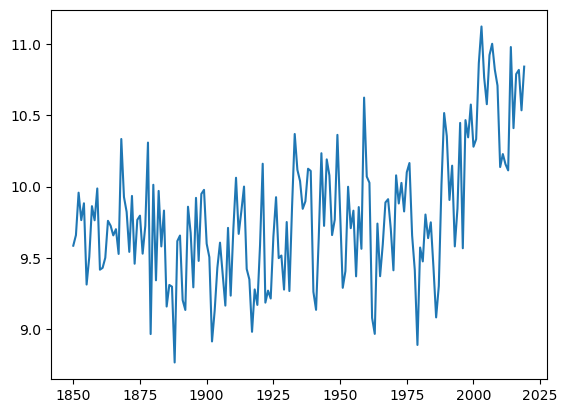

In [193]:
year_sst = []
for i in range(0, len(temperature), 12):
    year_sst.append(np.mean(temperature[i:i+12]))
plt.plot(np.arange(1850, 2020, 1),year_sst)

In [194]:
from statsmodels.tsa.stattools import adfuller
### do stationarity test
print(adfuller(year_sst))
### the result reveals that the data is not stationary

(-2.1140968591727876, 0.23888409439462238, 4, 165, {'1%': -3.470616369591229, '5%': -2.8792214018977655, '10%': -2.57619681359045}, 146.3834169538908)


In [195]:
def difference(data, interval=1):
    return [data[i+interval]-data[i] for i in range(len(data)-interval)]
difference_sst = difference(year_sst)
print(adfuller(difference_sst))
### the difference data is stationary, hence d = 1 for ARIMA model
### then do the white noise test
print(acorr_ljungbox(difference_sst, lags=1))
### here the p-value is e-7, which is less than 0.05, hence the data is not white noise

(-5.825718199188643, 4.0839208254806955e-07, 13, 155, {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}, 146.28256452689237)
     lb_stat     lb_pvalue
1  27.779432  1.359639e-07


/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_42708/3277459133.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(difference_sst).show()
/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_42708/3277459133.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(difference_sst).show()


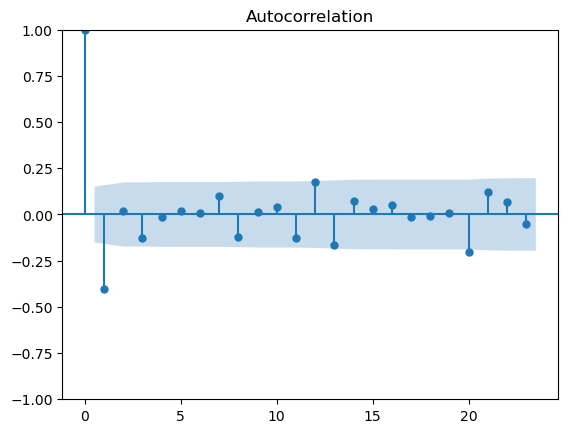

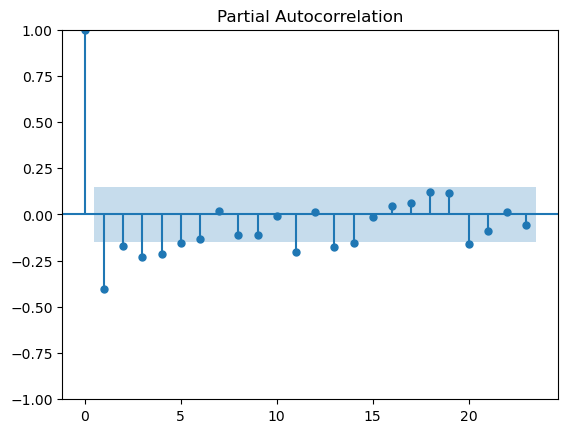

In [196]:
### then plot acf and pacf to find p and q
### first change data to np array
difference_sst = np.array(difference_sst)
plot_acf(difference_sst).show()
plot_pacf(difference_sst).show()


In [198]:
### then use AIC and BIC to find the best p and q
train_results = sm.tsa.arma_order_select_ic(difference_sst, ic=['aic', 'bic'], trend='n', max_ar=8, max_ma=8)
 
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

AIC (8, 8)
BIC (1, 1)


/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x800 with 0 Axes>

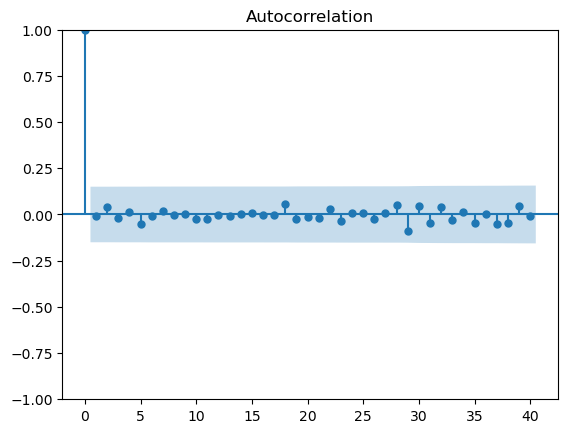

In [201]:
year_sst = np.array(year_sst)
model = sm.tsa.ARIMA(year_sst, order=(8, 1, 8))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40)
plt.show()
### the ploting result shows that the residual error is white noise

In [202]:
model = sm.tsa.ARIMA(year_sst, order=(8, 1, 8))
results = model.fit()
future_sst = results.forecast(steps=50)
print(future_sst)

[10.85360456 10.95955969 10.70562945 10.90726615 10.56020329 10.4359877
 10.60723822 10.37088096 10.60452362 10.63522066 10.76175041 10.71332531
 10.75976759 10.85393624 10.54033084 10.80349624 10.65056789 10.56600488
 10.73733679 10.61262033 10.68170864 10.61113154 10.76803889 10.6141761
 10.63822653 10.82056829 10.53480273 10.74385394 10.70325927 10.62554548
 10.68859268 10.67344754 10.71247778 10.56383834 10.78723924 10.64200028
 10.59366056 10.80546203 10.58873394 10.68582516 10.69338338 10.68657179
 10.63651266 10.67307545 10.75958172 10.54018788 10.76222526 10.69108037
 10.58286015 10.75511729]


/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


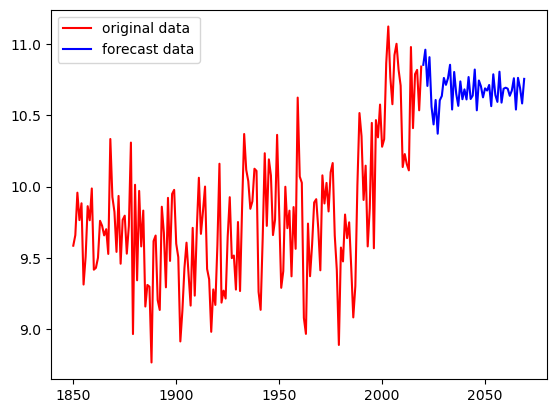

In [207]:
### now plot the original data and the forecast data together
plt.plot(np.arange(1850, 2020, 1), year_sst, "r", label="original data")
plt.plot(np.arange(2020, 2070, 1), future_sst, "b", label="forecast data")
plt.legend()
plt.show()

In [ ]:
def read_ssttemper():
    temperFn = r"sst.mon.mean.nc"
    tfid = nc.Dataset(temperFn)
    lon = tfid.variables['lon'][:]
    lat = tfid.variables['lat'][:]
    sst = tfid.variables['sst'][0, :, :] # air temperature unit: degK
    return lon, lat, sst
def plot_ssttemper():
    lon, lat, sst = read_ssttemper()
    proj = ccrs.PlateCarree(central_longitude=180)
    fig = plt.figure(figsize=(9, 6), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    cs = ax.contourf(lon, lat, sst, transform=proj, cmap='RdBu_r') 
    ax.coastlines(color='dimgray')
    ax.set_global()
    cbar = fig.colorbar(cs, orientation='vertical', pad=0.02, aspect=20, shrink=0.6)
    cbar.set_label('degK')

    xticks = [-180, -120, -60, 0, 60, 120, 180]
    ax.set_xticks(xticks, crs=proj)
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
    lon_formatter = mticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = mticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    plt.savefig(r'test.jpg', dpi=300)
    plt.show()
